# Cardiovascular disease Prediction

Cardiovascular diseases are the No.1 reason for all deaths in the world [[WHO](https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds))].

There are many subgroups of different kind of diseases centred around the heart and the blood vessels:

- coronary heart disease – disease of the blood vessels supplying the heart muscle
- cerebrovascular disease – disease of the blood vessels supplying the brain
- peripheral arterial disease – disease of blood vessels supplying the arms and legs
- rheumatic heart disease – damage to the heart muscle and heart valves from rheumatic fever, caused by streptococcal bacteria
- congenital heart disease – malformations of heart structure existing at birth
- deep vein thrombosis and pulmonary embolism – blood clots in the leg veins, which can dislodge and move to the heart and lungs.

The typical risk factors of Cardiovascular diseases are:

- Behavioral:
    - diet,
    - physical inactivity,
    - tobacco use and
    - harmful use of alcohol.

- Medical Values:
    - raised blood pressure,
    - raised blood glucose,
    - raised blood lipids and
    - overweight & obesity


The risk factors mentioned above are quite numerous, and a doctor is only so good at asking questions and data control.
Our motivation for this project is to help doctors and patients by providing a tool that is able to make a prediction of how likely it is that
one will be subjected to a cardiovascular disease.

The objective is to use data recordings of 70 000 patients, including 11 different Features to predict a Cardiovascular Disease. This disease is a leading cause of death and many are preventable. The Machine Learning model might therefore be a useful tool to bring attention to early stages and to minimize examination mistakes by providing a second opinion.


## Dataset

To make this prediction possible we found a dataset containing said risk factors as features, and the label based on the Cardiovascular disease status.
This dataset is taken from Kaggle.com and can be found [here](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset).

The dataset has 70 000 rows and 13 columns. There are 3 types of input features:

* Objective: factual information
* Examination: results of medical examination
* Subjective: information given by the patient

| [0] id| [1] age| [2] gender| [3] height| [4] weight|
| ---| ---| ---| ---| ---|
| int| int| 1 or 2 | int| float|
| -| days| categorical code (2=men)| cm| kg |
| -| Objective| Objective| Objective| Objective |

| [5] ap_hi| [6] ap_lo| [7] cholesterol| [8] gluc|
| ---| ---| ---| ---|
| int| int| 1, 2, 3 | 1, 2, 3 |
| -| -| normal, above normal, well above normal| normal, above normal, well above normal|
| Examination| Examination| Examination| Examination|

>Note: ap_hi = Systolic blood pressure, ap_lo = Diastolic blood pressure, gluc = Glucose

| [9] smoke| [10] alco| [11] active| [12] cardio|
| ---| ---| ---| ---|
| binary| binary| binary| binary |
| -| -| -| categorical code|
| Subjective| Subjective| Subjective| Target|

>Note: alco = Alcohol intake



## EDA - Data Correlation

A good start for choosing the correct prediction algorithm is an exploratory data analysis (EDA).
This analysis looks at the data and shows potential correlations or problems.

More information and details can be found in this [report](../docs/CardioVascular-Diseas-Prediction.html).
This report was compiled using the [pandas-profiling tool](https://github.com/pandas-profiling/pandas-profiling)

 - Our results show that some data is corrupt and needs to be fixed (e.g. implausible blood pressure values).
 - The data is not linear separable, so we definitely need a good feature function or kernel.
 - The result of the prediction should be a label and not a value, so we want a classifier.


Based on the these results a good choice for a prediction algorithm in our project is the **Kernel Logistic Regression**.


Based on the WHO's [cardiovascular risk charts](https://www.who.int/news/item/02-09-2019-who-updates-cardiovascular-risk-charts)
being male/elderly/a smoker or having diabetes/high cholesterol levels are the most prominent risk factors for having a cardiovascular disease.


To get a better understanding of our data set and the relation between the variables, we compute the correlation matrix.


Text(0.5, 1.0, 'Correlation Matrix')

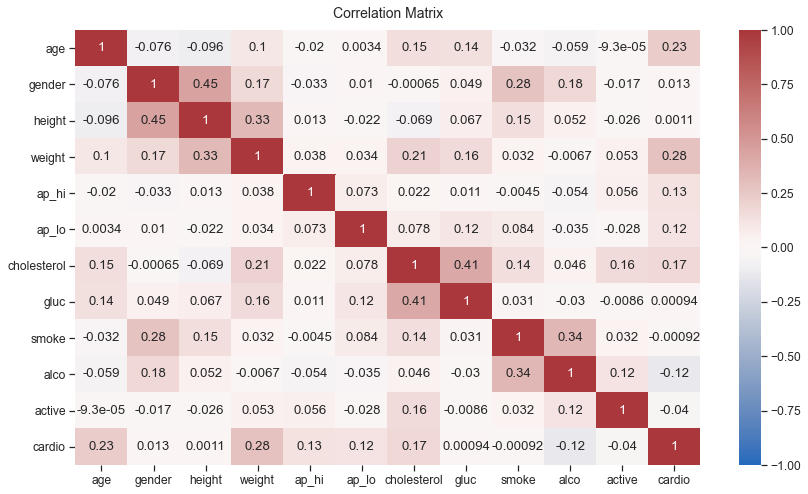

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
#plot_df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id')#.sample(1000, random_state=42)
plot_df = pd.read_csv('cardio_train.csv', sep=';', index_col='id').sample(300, random_state=42)

plt.figure(figsize=(14, 8))
sns.heatmap(plot_df.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.title('Correlation Matrix', fontdict={'fontsize':14}, pad=12)

## Data Abnormalities

By looking into the last column, we can see the variables of our dataset which correlate most to a cardiovascular disease.

In our case the biggest influences are the features age,  (with decreasing significance).
Contrary to the aforementioned WHO's cardiovascular risk charts, the gender of a person is of minor importance.
Surprisingly, smoking and high alcohol intake seem to lessen the risk of cardiovascular disease.
Perhaps these features may have gotten mixed up during data collection, but as this is a kaggle-dataset with no reference to the original source,
we cannot know for sure.

We plot the features 'age' and 'weight' in order to visualize the trend in the data. 

As expected, there tends to be more healthy cases in the lower left part of the scatter plot (low age/low weight) than in the upper right (high age/high weight). Nevertheless, it should also be noted that there are many outliers, as well as some values that don't make any sense (e.g. an adult person with only 10 kg). It may be advantagious to exclude these outliers before training our model.

Text(0, 0.5, 'weight in kg')

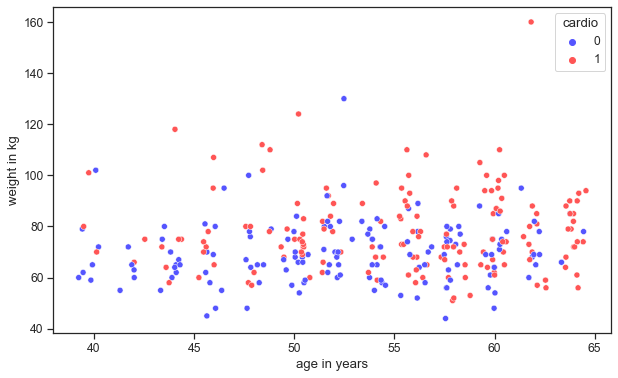

In [2]:
# take age & round days to years
age = plot_df['age']
age_divider = 1.0/365.0
age = age * age_divider
#
# create age data in correlation with cardio
age_data = pd.concat([age, plot_df['weight'], plot_df['cardio']], axis=1, join='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='weight', data=age_data, hue='cardio', palette="seismic")
# TODO label into ['cardio true', 'cardio false']
plt.xlabel('age in years')
plt.ylabel('weight in kg')


ToDo Vinc: mention age abnormalities (gerades Alter wahrscheinlicher als ungerades, keine Werte zwischen 30 und 39!)

ToDo Leo: are there any duplicate rows?

## Kernel Logistic Regression

### Imports

In [3]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

### Kernel / Feature function

For the best result we want to include all of our risk factors. In other words, we want a Feature Function with all our features.
Based on our EDA we can say that our data is not linear separable. There might a case our where data is linear separable,
but instead of finding the best feature function or introducing an extra dimension to make the data linear separable,
we kernelize our feature function.

$h(x) = w^T * \Phi(x_i)= w^T*K(x,z) = w^T * (x^T*z+1)^d $

$ min J(w) = \frac{1}{m} \sum_{i=1}^{m} l(h(x_i), y_i) + \Omega(w)$

### Load Data

In [5]:
print('-'*30); print("IMPORTING DATA");print('-'*30)
# limit dataset to 5000 instances for testing purposes (memory issues)
#df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id').sample(500, random_state=42)
df = pd.read_csv('cardio_train.csv', sep=';', index_col='id').sample(300, random_state=42)
# df = pd.read_csv('../resources/cardio_train.csv', sep=';', index_col='id')

------------------------------
IMPORTING DATA
------------------------------


## Outliers

As we saw in the explorative data analysis, there are some data points that don't make any sense. Therefore we define reasonable value ranges for the blood pressure/weight/height features in order to account for any errors during the data collection process.  

In [6]:
org_count = len(df)

df = df[(50 <= df['ap_lo']) & (df['ap_lo'] <= 150)]
df = df[(100 <= df['ap_hi']) & (df['ap_hi'] <= 200)]

df = df[(25 <= df['weight']) & (df['weight'] <= 400)]
df = df[(100 <= df['height']) & (df['height'] <= 210)]

new_count = org_count - len(df)
print(f"{new_count} entries have been excluded due to implausible feature values.")

11 entries have been excluded due to implausible feature values.


### Feature Scaling

Our dataset includes corrupt values and has outliers that need to be expelled before we can make a solid prediction.
The information provided by the dataset depends on the category. While some are binary values are
numerical on a scale like weight and height.
To reduce noise between the features we need to normalize these data points to a similar scale, this process is called feature scaling.

Feature Scaling is necessary because if the range of raw data varies widely, it can be the case that the objective function of some machine learing algorithms will not work properly. This is also the case for the Kernel Feature Function. 

The main reason for this is that the Kernel Logistic Regression Algorithm calculates the Squared/Euclidean distance between the Feature Points. If one Feature has a broad value range the distance is determined and influenced only by this particular feature.

Since the Cardiovascular Disease Dataset has a broad value range for example for the Feature 'age' (given in days), we standardize our data such that all features has a mean of zero and a standard deviation of 1. Therefore, we use the standardization formular:

$\tilde{x_i} = \frac{x_i - \mu}{\sigma}$

In [7]:
import statistics

def standardize(feature):
    return (feature-statistics.mean(feature)) / statistics.stdev(feature)

df['age_standardized'] = standardize(df['age'])
df['height_standardized'] = standardize(df['height'])
df['weight_standardized'] = standardize(df['weight'])
df['ap_lo_standardized'] = standardize(df['ap_lo'])
df['ap_hi_standardized'] = standardize(df['ap_hi'])

# use [1, -1] as class labels
df['cardio'] = df['cardio'].apply(lambda t: 1 if t==1 else -1).values

## Implement functions

### squared exponential kernel $k(x,z)$
$k(x,z) = exp(− x^Tx−2x^Tz+z^Tz/ 2σ^2) = exp(sqdist(x,z)/2σ^2)$

### hypothesis function $h(x)$
$h_\alpha(x) = \alpha K = \sum_{j=1}^{m} \alpha_j k(x_j,x)$

### loss function $l(h(x),y)$

logistic loss:
$l_{logistic}(h_\alpha(x), y) = log(1 + e^{−y·h(x)})= log(1 + exp(−y · h_\alpha(x)))$

### $l_2$ regularizer

$r = \lambda l_2 = \lambda\alpha^{\intercal}K\alpha$


### objective function J

  kernlized logistic regression

reuslting in a regularized kernlized logistic:
$
J(\alpha) = \frac{1}{m}\sum_{i=1}^m  \log \big(1 + \exp\big(-y_i \cdot \sum_{j=1}^{m} \alpha_j k(x_j,x_i)\big) \big) + \lambda \alpha^{\intercal}K\alpha
$

In [8]:
def sqdist(X, Z):
    p1 = np.sum(X**2, axis=1)[:, np.newaxis]
    p2 = np.sum(Z**2, axis=1)
    p3 = -2 * np.dot(X, Z.T)
    return p1+p2+p3

def sq_exp(X, Z, sigma):
    return np.exp(-sqdist(X, Z)/(2*sigma**2) )


def J(α, X, y, sigma, lam):
    K = sq_exp(X, X, sigma)
    m = X.shape[0]
    total_loss = 0
    regularization = lam * np.dot(np.dot(np.transpose(α), K), α)

    for i in range(m):
        prediction = 0
        for j in range(m):
            prediction += α[j]*K[i][j]
        logistic_loss = np.log(1 + np.exp(-y[i] * prediction))
        total_loss += logistic_loss

    mean_loss = total_loss / m  + regularization
    return mean_loss

Implement the gradient of the regularized kernlized logistic regression objective.

In [9]:
def dJ(α, X, y, sigma, lam):
    K = sq_exp(X, X, sigma)
    m = X.shape[0]
    gradient = 0
    regularization = 2*lam * np.dot( K, α)

    for i in range(m):
        prediction = 0
        for j in range(m):
            prediction += α[j]*K[i][j]

        numerator = -y[i] * K[i]
        denominator = 1 + np.exp(y[i] * prediction)
        gradient += numerator / denominator

    mean_gradient = gradient / m + regularization
    return mean_gradient


## Train model

In [10]:
from scipy.optimize import minimize

def kernel_lr(X, y, sigma, lam):
    # implementation of kernel ridge regression using the scipy optimizer gradient descent
    α = np.zeros(X.shape[0],)
    α = minimize(J, α, args=(X, y, sigma, lam), jac=dJ, method='CG').x
    h = lambda Z: np.dot(α, sq_exp(X, Z, sigma))
    return h

## Split data in Train / Validation / Test

We'll first split our data into a Train set (70%) and Test set (30%).  
The training set will be further processed using 10-fold-cross-validation.

In [11]:
def train_test_split(data, train_proportion=0.7, shuffle=False):
    if shuffle:
        indices = np.random.permutation(data.shape[0])
    else:
        indices = np.arange(data.shape[0])

    split_index = int(train_proportion * data.shape[0])
    training_idx = indices[:split_index]
    test_idx = indices[split_index:]

    return data[training_idx, :], data[test_idx, :]


def cross_val(data, k=10):
    assert k >= 2
    datasets = []

    if data.shape[0] % k != 0:
        print("warning: this dataset contains {} entries and cannot be equally divided into {} chunks for cross-validation.".format(data.shape[0], k))
        print("Prutruding rows will be dropped.")
        data = data[ : (data.shape[0] // k) * k]

    for i in range(k):
        data_chunks = np.split(data, k)

        val_data = data_chunks.pop(i)
        train_data = np.concatenate(data_chunks)
        datasets.append((train_data, val_data))

    return datasets

def get_labels_and_features(dataset:np.ndarray)->Tuple[np.ndarray, np.ndarray]:
    """Return labels and features from a given dataset.
    :return: labels, features
    """
    # [0] age - [10] active
    # [11] cardio
    # [12] scaled age - [22]...
    col = {
        'age':0, 'gender': 1, 'height':2 , 'weight': 3, 'ap_hi': 4, 'ap_lo': 5, 'cholesterol': 6,
        'gluc': 7, 'smoke': 8, 'alco': 9, 'active': 10, 'cardio': 11, 'age_standardized': 12, 'height_standardized': 13, 
        'weight_standardized': 14, 'ap_lo_standardized': 15, 'ap_hi_standardized': 16
           }
    feature_list = [
        col['age_standardized'], col['weight_standardized'], col['cholesterol'], col['gluc'], col['ap_lo_standardized'],
        col['ap_hi_standardized']
        ]

    labels = dataset[:, col['cardio']]
    features = dataset[:, feature_list]
    return labels, features


In [12]:
cardio_data = df.to_numpy()
train_data, test_data = train_test_split(cardio_data, shuffle=False)
datasets = cross_val(train_data, k=2)

## Evaluate minimized hypothesis function $h$

TODO Vinc: Beschreiben unserer measures against over and underfitting

In [42]:
import matplotlib.pyplot as plt

def score(h, X, y):
    predictions = h(X)

    score = (predictions*y >= 0).astype(int)
    return score.sum()/score.shape[0]

def train_n_score(datasets, sigma, lam):
    train_accuracy = []
    val_accuracy = []
    for train_set, val_set in datasets:
        y_train, X_train = get_labels_and_features(train_set)
        y_val, X_val = get_labels_and_features(val_set)

        h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

        train_accuracy.append(score(h, X_train, y_train))
        val_accuracy.append(score(h, X_val, y_val))

    #print(f'Average model accuracy for sigma={sigma}, lambda={lam}')
    #print(f'train: {sum(train_accuracy)/len(train_accuracy)}')
    #print(f'val: {sum(val_accuracy)/len(val_accuracy)}\n')
    
    return train_accuracy, val_accuracy

"""
#sigmas=[2., 4., 6.]
sigmas = np.linspace(0.5, 10, 15)
lambdas=[0] #1e-2
#lambdas=np.exp(np.linspace(np.log(1e-6), np.log(0.1), 15))

generalization_error = []
train_error = []
train_accuracy = []
val_accuracy = []

for lam in lambdas:
    for sigma in sigmas:
        train_accuracy, val_accuracy = train_n_score(datasets, sigma, lam)
        generalization_error.append(1-(sum(val_accuracy)/len(val_accuracy)))
        train_error.append(1-(sum(train_accuracy)/len(train_accuracy)))
                                    
plt.plot(sigmas, generalization_error, label='generalization error', color='orange')
plt.plot(sigmas, train_error, label='train error', color='royalblue')
plt.ylim([0, .6]);
plt.xlabel('$\sigma$')
plt.ylabel('error')
plt.legend(loc='upper center');
# TODO Jan: show generalization error in plot, or plots for lambda / simga changes
# compare: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
"""

"\n#sigmas=[2., 4., 6.]\nsigmas = np.linspace(0.5, 10, 15)\nlambdas=[0] #1e-2\n#lambdas=np.exp(np.linspace(np.log(1e-6), np.log(0.1), 15))\n\ngeneralization_error = []\ntrain_error = []\ntrain_accuracy = []\nval_accuracy = []\n\nfor lam in lambdas:\n    for sigma in sigmas:\n        train_accuracy, val_accuracy = train_n_score(datasets, sigma, lam)\n        generalization_error.append(1-(sum(val_accuracy)/len(val_accuracy)))\n        train_error.append(1-(sum(train_accuracy)/len(train_accuracy)))\n                                    \nplt.plot(sigmas, generalization_error, label='generalization error', color='orange')\nplt.plot(sigmas, train_error, label='train error', color='royalblue')\nplt.ylim([0, .6]);\nplt.xlabel('$\\sigma$')\nplt.ylabel('error')\nplt.legend(loc='upper center');\n# TODO Jan: show generalization error in plot, or plots for lambda / simga changes\n# compare: https://en.wikipedia.org/wiki/Receiver_operating_characteristic\n"

## Training and Generalization Error without regularization

Since we have no idea how our model perform, we start to train it on different $\sigma$ at first without any regularization.

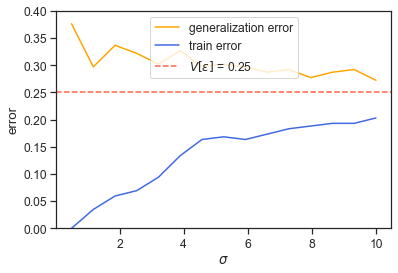

In [39]:
## Achtung Auswertung benötigt > 2h !!!
"""
#sigmas=[2., 4., 6.]
sigmas = np.linspace(0.5, 10, 15)
lambdas=[0] #1e-2
#lambdas=np.exp(np.linspace(np.log(1e-6), np.log(0.1), 15))

generalization_error = []
train_error = []
train_accuracy = []
val_accuracy = []

for lam in lambdas:
    for sigma in sigmas:
        train_accuracy, val_accuracy = train_n_score(datasets, sigma, lam)
        generalization_error.append(1-(sum(val_accuracy)/len(val_accuracy)))
        train_error.append(1-(sum(train_accuracy)/len(train_accuracy)))
"""
plt.figure(figsize=(10, 6))
plt.plot(sigmas, generalization_error, label='generalization error', color='orange')
plt.plot(sigmas, train_error, label='train error', color='royalblue')
plt.axhline(0.25, color='tomato', linestyle='--', label=f'$V[\epsilon]$ = {0.25}')
plt.ylim([0, .4]);
plt.xlabel('$\sigma$')
plt.ylabel('error')
plt.legend(loc='upper center');

As there can be seen there is a huge gap between Train Error and Generalization Error. This means we have a high variance problem and our model is overfitting. Therefore, we add Regularization to reduce our model complexity. Another possibility would be to add more data, however this is problematic due to the computational time.

Lets add a Regularization parameter $\lambda$.

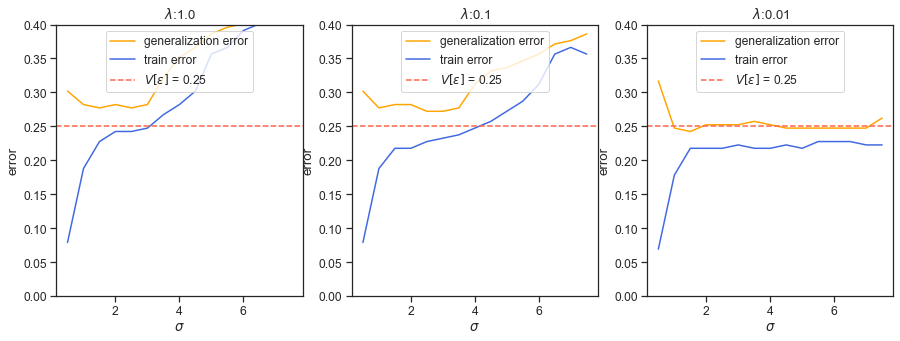

In [50]:
sigmas = np.linspace(0.5, 7.5, 15)
lambdas=[1., 0.1, 0.01] #1e-2
#lambdas=np.exp(np.linspace(np.log(1e-6), np.log(0.1), 15))

fig, axs = plt.subplots(1, len(lambdas), figsize=(15, 5))
for i, lam in enumerate(lambdas):
    generalization_error = []
    train_error = []
    train_accuracy = []
    val_accuracy = []
    plt.sca(axs[i])
    for sigma in sigmas:
        train_accuracy, val_accuracy = train_n_score(datasets, sigma, lam)
        generalization_error.append(1-(sum(val_accuracy)/len(val_accuracy)))
        train_error.append(1-(sum(train_accuracy)/len(train_accuracy)))

    plt.plot(sigmas, generalization_error, label='generalization error', color='orange')
    plt.plot(sigmas, train_error, label='train error', color='royalblue')
    plt.axhline(0.25, color='tomato', linestyle='--', label=f'$V[\epsilon]$ = {0.25}')
    plt.ylim([0, .4]);
    plt.xlabel('$\sigma$')
    plt.ylabel('error')
    plt.title(f'$\lambda$:{lam}')
    plt.legend(loc='upper center');

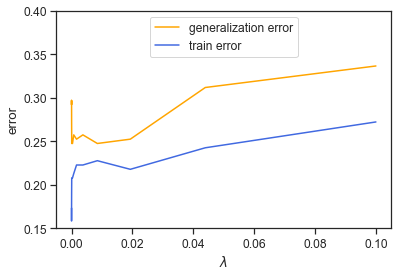

In [26]:
#curves for 15 log scaled lambdas ranging from 1e-6 to 0.1 

plt.plot(lambdas, generalization_error, label='generalization error', color='orange')
plt.plot(lambdas, train_error, label='train error', color='royalblue')
plt.ylim([0.15, .4]);
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.legend(loc='upper center');

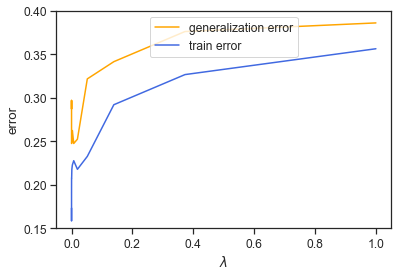

In [24]:
#curves for 15 log scaled lambdas ranging from 1e-6 to 1 

plt.plot(lambdas, generalization_error, label='generalization error', color='orange')
plt.plot(lambdas, train_error, label='train error', color='royalblue')
plt.ylim([0.15, .4]);
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.legend(loc='upper center');

## Metrics

In [13]:
sigma = 6
lam = 1e-4
y_train, X_train = get_labels_and_features(train_data)
y_test, X_test = get_labels_and_features(test_data)
h = kernel_lr(X_train, y_train, sigma=sigma, lam=lam)

	---- Metrics ----
Accuracy:	 0.7777777777777778
Precision:	 0.7924528301886793
Recall:		 0.6666666666666666
F1:		 0.7241379310344827

	---- Confusion Matrix ----


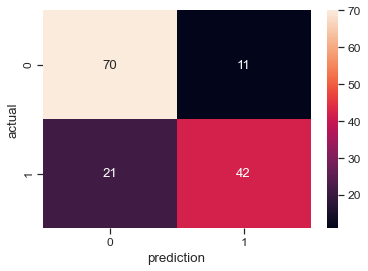

We predicted correctly that 70 patients have no disease.
We predicted correctly that 42 patients have a cardio disease.
But we missed 21 patients and gave 11 false alarms.



In [14]:
X, y =  X_test, y_test

predictions = h(X)
matching_score = (predictions * y >= 0).astype(int)

# true disease, false alarm, no disease, missed
tp, fp, tn, fn = [], [], [], []
for index, score in enumerate(predictions):
    label = y[index]
    if score > 0 and label > 0:
        tp.append(score)
    elif score > 0 and label < 0:
        fp.append(score)
    elif score < 0 and label < 0:
        tn.append(score)
    elif score < 0 and label > 0:
        fn.append(score)

# How many predictions were correct out of all predictions possible.
accuracy = matching_score.sum() / matching_score.shape[0]
# The fraction of relevant instances retrieved from total instances retrieved. Aka. The number of correct prediction among the cases of cardio predicted.
# ex. there are 80 cases of true cardio predicted but 100 prediction for cardio made, so 20 were unnecessary.
precision = len(tp)/ (len(tp)+ len(fp))
# The fraction of relevant instances retrieved over the total relevant instances retrieved. Aka. What percent of all cases of cardio disease did the model find.
# ex. there where 80 cases of true cardio predicted but in totale exited 84 cases, so 4 slipped.
recall = len(tp) / (len(tp) + len(fn))

# F1 is the harmonic mean of precision and recall.
f_1 = 2 * ( (precision * recall) / (precision + recall) )
print('\t---- Metrics ----\n'
    f'Accuracy:\t {accuracy}\n'
    f'Precision:\t {precision}\n'
    f'Recall:\t\t {recall}\n'
    f'F1:\t\t {f_1}\n')
print('\t---- Confusion Matrix ----')
plot_data = [[len(tn), len(fp)],
             [len(fn), len(tp)]]
sns.heatmap(plot_data, annot=True)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()
print(f'We predicted correctly that {len(tn)} patients have no disease.\n'
    f'We predicted correctly that {len(tp)} patients have a cardio disease.\n'
    f'But we missed {len(fn)} patients and gave {len(fp)} false alarms.\n')

# true positive rate (tpr) & true negative rate (tnr)
tpr = recall
tnr =  len(tn)/(len(tn)+len(fp))

ToDo: Generalisierungsfehler schätzen mit Test-Datensatz -> Hausnummer 4


## Further Cases

Cardiovascular disease Prediction

TODO Vinc: Ausblick -> z.B. andere Lern algorithm, ensemble Methoden wie adaboost, ...
Ausblick wenn mehr Zeit - do we want to show any differences compared to decision trees , SVM's, etc...

